In [16]:
import cv2 as cv
import os
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchinfo import summary
import torchmetrics
from sklearn.metrics import accuracy_score

In [24]:
def displayImage(image, title=""):
    if (len(image.shape) == 3):
        cmap = None
    else:
        cmap = "gray"
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

# Dataset

In [25]:
# get train and validation datasets
images_directory = "../dataset/images"
annotations_directory = "../dataset/annotations"

with open("train.txt") as train:
    train_images_filenames = sorted(train.read().splitlines())

with open("test.txt") as test:
    val_images_filenames = sorted(test.read().splitlines())

# filter out images that can not be loaded properly
train_images_filenames = [i for i in train_images_filenames if cv.imread(
    os.path.join(images_directory, i + ".png")) is not None]
val_images_filenames = [i for i in val_images_filenames if cv.imread(
    os.path.join(images_directory, i + ".png")) is not None]

random.seed(42)
random.shuffle(train_images_filenames)
random.shuffle(val_images_filenames)

print(len(train_images_filenames), len(val_images_filenames))


613 264


In [35]:
class TrafficSignDataset(Dataset):
    def __init__(self, images_filenames, images_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv.imread(os.path.join(
            self.images_directory, image_filename + ".png"))
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # transform image into 0-1 range
        # note that the ToTensorV2 method from the albumentations library does not automatically convert the image range into 0-1
        image = image / 255.

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image


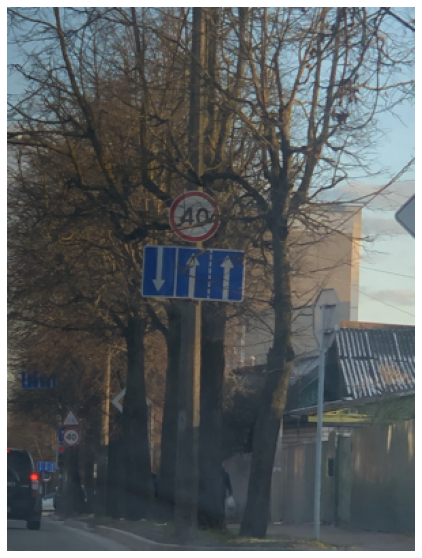

In [36]:
train_dataset = TrafficSignDataset(train_images_filenames, images_directory)


displayImage(train_dataset[10])